In [ ]:
!pip install keras

In [ ]:
!pip show tensorflow

In [ ]:
!pip install pandas openpyxl

In [ ]:
!pip install transformers


### IMPORT

In [99]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
import tensorflow_hub as hub
import matplotlib.pyplot as plt
from tensorflow.python.keras import metrics
# from tensorflow.keras import metrics
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns


### DATA PREPROCESSING

#### IMPORT & INFO 
 ORIGIN DATA - DATA WITH CAHTGPT LABALING

In [100]:
# Load the CSV file
data = pd.read_csv('GPTClassification.csv')
data.name = 'origin_df'
data.shape

(364, 2)

In [101]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  364 non-null    object
 1   category  362 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


In [102]:
data.head(10)

,Sentence,category
0,"""I think there should be many various sitting ...",Land use
1,"""It should be distinctive but still matching t...",Local identity
2,"""It should be clear where the entrance is and ...",Land use
3,"""well I think that the spaces should be focuse...","Land use, Future of work"
4,"""well it could be achieved through different m...",Land use
5,"""yes, the current building, as unsuitable as i...",Local identity
6,"""maybe, however Im interested in your suggesti...",other
7,"""i find that a very correct approach... how di...",other
8,"""correct again """,other
9,"""well maybe it is a possibility to experiment ...",Local identity


#### CLEAN DATA

In [103]:
empty_string_count = (data['category'] == 'other').sum()
print("There is ", empty_string_count, " sentence that are not labeled")

There is  93  sentence that are not labeled


In [104]:
# delete the NuN values
data = data.dropna()

In [105]:
total_duplicate_titles = sum(data["Sentence"].duplicated())
print(f"There are {total_duplicate_titles} duplicate Sentences.")

There are 14 duplicate Sentences.


In [106]:
# Create a boolean mask for duplicated sentences
mask = data["Sentence"].duplicated(keep=False)
print("DUPLICATE ROWS")
# Print the rows with duplicated sentences
data[mask]


DUPLICATE ROWS


,Sentence,category
17,"""no""",other
51,"""What spaces should be in the building?""","Future of work, Land use"
54,"""What should the building look like? """,Local identity
71,"""What spaces should be in the building?""",Land use
74,"""What should the building look like? """,Local identity
85,"""Hi Zaha""",other
97,"""What would you like to know""",other
123,"""spaces""","Environment and climate resilience, Land use"
127,"""trees grass""","Environment and climate resilience, Land use"
129,"""spaces""","Environment and climate resilience, Land use"


In [107]:
data = data[~data["Sentence"].duplicated()]
print(f"duplicate rows:  {len(data)}")

# There are some categories with occurrence as low as 1.
print("categories upon once only:",sum(data["category"].value_counts() == 1))

# How many unique terms?
print("unique categories:",data["category"].nunique())

duplicate rows:  348
categories upon once only: 14
unique categories: 31


We need to handle the categories upon only once, its problematic for multi-label text classifier

In [108]:
def get_single_occurrence_categories(data):
    # Get the categories that appear only once
    single_occurrence_categories = data['category'].value_counts()
    single_occurrence_categories = single_occurrence_categories[single_occurrence_categories == 1].index

    # Get the rows where 'category' is in the list of single-occurrence categories
    once_sen = data[data['category'].isin(single_occurrence_categories)]
    return once_sen


In [109]:
print("sentences that their label is unique in the data set:")
once_sen = get_single_occurrence_categories(data)
once_sen


sentences that their label is unique in the data set:


,Sentence,category
15,"""hi, i think if there´s more free use co-worki...","Local identity, Environment and climate resili..."
19,"""The building should be more open for the soci...","Local identity, Environment and climate resili..."
22,"""To have a cafe on the ground floor would be n...","Local identity, Mobility (transport)"
53,"""Can we have a garden?""","Land use, Environment and climate resilience"
110,"""I agree! Architecture students should be insp...","Environment and climate resilience, Future of ..."
145,"""The building should have several spaces for g...","Environment and climate resilience, Local iden..."
183,"""Can I 3d print infra lightweight concrete?""",Future of work; Land use
194,"""I think it should be more inviting compared t...",Local identity; Land use
198,"""There should be greenery aroud the building, ...",Environment and climate resilience; Land use
226,"""I think that a good architecture school shoul...",Land use; Local identity


In [110]:
# Replace ";" with ","
data['category'] = data['category'].str.replace(';', ',')


In [111]:
data["category"] = data["category"].apply(
    lambda x: x.split(', ')
)
data["category"].values[:5]


array([list(['Land use']), list(['Local identity']), list(['Land use']),
       list(['Land use', 'Future of work']), list(['Land use'])],
      dtype=object)

In [112]:
print("after replace ';', \nsentences that their label is unique in the data set: ")
once_sen = get_single_occurrence_categories(data)
once_sen

after replace ';', 
sentences that their label is unique in the data set: 


,Sentence,category
15,"""hi, i think if there´s more free use co-worki...","[Local identity, Environment and climate resil..."
19,"""The building should be more open for the soci...","[Local identity, Environment and climate resil..."
22,"""To have a cafe on the ground floor would be n...","[Local identity, Mobility (transport)]"
53,"""Can we have a garden?""","[Land use, Environment and climate resilience]"
110,"""I agree! Architecture students should be insp...","[Environment and climate resilience, Future of..."
145,"""The building should have several spaces for g...","[Environment and climate resilience, Local ide..."
239,"""Hello Zaha, nice to meet you! I'm glad to be ...","[Environment and climate resilience, Local ide..."
316,"""I hope in office room or big classroom there ...",[Indoor comfort]
335,"""Who's your favorite architect what's your fav...","[Mobility (transport), Local identity]"


The categories that appear once in the data we took from 14 to 9.
Now for those 9 - we will separate them to different rows

In [113]:
# Create a list to store the new rows
new_rows = []

# Iterate over the rows in the dataframe where category is in single_occurrence_categories
for idx, row in once_sen.iterrows():
    # Iterate over the categories in the 'category' column
    for cat in row['category']:
        new_row = {'Sentence': row['Sentence'], 'category': [cat]}
        # Only add the new row if it is not already in new_rows
        if new_row not in new_rows:
            new_rows.append(new_row)
    data = data.drop(idx)

# Create a new DataFrame from the new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the dataframe using concat
data = pd.concat([data, new_rows_df], ignore_index=True)


In [114]:
# Convert lists in 'category' to tuples
new_rows_df['category'] = new_rows_df['category'].apply(tuple)

# Then check for duplicates
total_duplicate_titles = new_rows_df.duplicated().sum()
print(f"There are {total_duplicate_titles} duplicates.")



There are 0 duplicates.


In [115]:
# There are some categories with occurrence as low as 1.
print(once_sen['Sentence'][19])
data[data['Sentence'] == once_sen['Sentence'][19]]
# this cell for checking it was separated

"The building should be more open for the society."


,Sentence,category
342,"""The building should be more open for the soci...",[Local identity]
343,"""The building should be more open for the soci...",[Environment and climate resilience]


In [116]:
data.shape

(361, 2)

In [117]:
# Get the categories that appear more than once
multi_occurrence_categories = data['category'].value_counts()
multi_occurrence_categories = multi_occurrence_categories[multi_occurrence_categories > 1].index

# Filter the data to only include rows where 'category' is in the list of multi-occurrence categories
data = data[data['category'].isin(multi_occurrence_categories)]


In [118]:
data.shape

(360, 2)

#### SPLIT DATA - train, validation, test

In [119]:
test_split = 0.3


# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["category"].values,
    random_state=42
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")



Number of rows in training set: 252
Number of rows in validation set: 54
Number of rows in test set: 54


#### MULTI HOT ENCODING
We will convert the  categorical data into a form that can be used by deep learning models.
because we are dealing with multi-label classification problem.


In [120]:
# Convert tensors to numpy arrays and then to sets of tuples for set operations
train_categories_tensor = tf.ragged.constant(train_df["category"].values)
test_categories_tensor = tf.ragged.constant(test_df["category"].values)

train_categories = set(tuple(x) for x in train_categories_tensor.to_list())
test_categories = set(tuple(x) for x in test_categories_tensor.to_list())

categories_not_in_train = test_categories - train_categories

print(categories_not_in_train)


set()


the result is an empty set (set())- it means there are no categories that exist in the test set but not in the training set

In [121]:
categories = tf.ragged.constant(train_df["category"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(categories)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

Vocabulary:

['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


2023-05-25 10:23:44.258874: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [252]
	 [[{{node Placeholder/_0}}]]


In [122]:
sample_label = train_df["category"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")

Original label: ['Future of work']
Label-binarized representation: [[0. 0. 0. 0. 1. 0.]]


In [123]:
train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe()


count    252.000000
mean      13.579365
std       22.727681
min        1.000000
25%        5.000000
50%        8.000000
75%       14.000000
max      179.000000
Name: Sentence, dtype: float64

 the 75th percentile is at 13, meaning that 75% of the sentences have a length of 13 or less.
 and the maximum length observed is 179

#### MAKE DATASET OBJECT FROM DF

In [124]:

max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["category"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Sentence"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [125]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)


#### DATA DISTRIBUTION 

In [126]:
from collections import Counter

def label_distribution(df):
    flat_categories = [category for sublist in df["category"] for category in sublist]
    counts = Counter(flat_categories)
    print("distribution:")
    for category, count in counts.items():
        print(f"{category}: {count}")
    print("")

In [127]:
print("DATA")
label_distribution(data)
pd.DataFrame(data["Sentence"].apply(lambda x: len(x.split(" "))).describe())

DATA
distribution:
Land use: 108
Local identity: 73
Future of work: 48
other: 88
Environment and climate resilience: 76
Mobility (transport): 12



,Sentence
count,360.000000
mean,13.208333
std,22.649772
min,1.000000
25%,5.000000
50%,8.000000
75%,13.000000
max,179.000000


In [128]:
print("TRAIN")
label_distribution(train_df)
pd.DataFrame(train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe())

TRAIN
distribution:
Future of work: 33
Environment and climate resilience: 53
Local identity: 52
Land use: 75
other: 62
Mobility (transport): 8



,Sentence
count,252.000000
mean,13.579365
std,22.727681
min,1.000000
25%,5.000000
50%,8.000000
75%,14.000000
max,179.000000


In [129]:
print("\nVAL")
label_distribution(val_df)
pd.DataFrame(val_df["Sentence"].apply(lambda x: len(x.split(" "))).describe())


VAL
distribution:
Local identity: 16
Land use: 16
Environment and climate resilience: 10
other: 13
Future of work: 6
Mobility (transport): 1



,Sentence
count,54.000000
mean,15.574074
std,31.091224
min,1.000000
25%,4.000000
50%,8.000000
75%,12.000000
max,179.000000


In [130]:
print("\nTEST")
label_distribution(test_df)
pd.DataFrame(test_df["Sentence"].apply(lambda x: len(x.split(" "))).describe())


TEST
distribution:
other: 13
Environment and climate resilience: 13
Future of work: 9
Land use: 17
Mobility (transport): 3
Local identity: 5



,Sentence
count,54.000000
mean,9.111111
std,6.206104
min,1.000000
25%,5.000000
50%,7.500000
75%,12.750000
max,28.000000


In [131]:
print("EXAMPLE OF HOT-ENCODING")
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[1:2]):
    label = label_batch[i].numpy()[None, ...]
    print(label[0])
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")


EXAMPLE OF HOT-ENCODING
[1. 0. 0. 0. 0. 0.]
Abstract: b'"it should be climate neutral or even positive. Can we provide a good natural ventilation?"'
Label(s): ['Land use']
 


2023-05-25 10:23:53.212474: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [252]
	 [[{{node Placeholder/_0}}]]
2023-05-25 10:23:53.212940: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [252,6]
	 [[{{node Placeholder/_1}}]]


In [132]:
vocabulary = set()
train_df["Sentence"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print("vocabulary_size: ",vocabulary_size)

vocabulary_size:  996


### TF-IDF Model

In [133]:
from tensorflow.keras import layers
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

2023-05-25 10:23:55.819089: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [252,6]
	 [[{{node Placeholder/_1}}]]
2023-05-25 10:23:55.819512: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [252,6]
	 [[{{node Placeholder/_1}}]]


In [134]:
class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
       precision = self.precision.result()
       recall = self.recall.result()
       return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))

In [135]:
def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

### Create a text classification Model

In [136]:
from tensorflow.keras import layers
def make_model():
    mlp_model = tf.keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return mlp_model


## Train the model

#### class to evaluate the model

In [137]:
epochs = 16

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "binary_accuracy", #"binary_accuracy" checks for each position if the prediction is correct.
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        F1Score()
    ]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

Epoch 1/16


2023-05-25 10:24:09.116692: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [252]
	 [[{{node Placeholder/_0}}]]
2023-05-25 10:24:09.117360: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [252,6]
	 [[{{node Placeholder/_1}}]]


1/2 [==============>...............] - ETA: 2s - loss: 0.8444 - binary_accuracy: 0.4518 - precision: 0.2017 - recall: 0.6370 - f1_score: 0.3064

2023-05-25 10:24:11.413280: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_9' with dtype int64
	 [[{{node Placeholder/_9}}]]
2023-05-25 10:24:11.413560: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [996]
	 [[{{node Placeholder/_10}}]]


2/2 [==============================] - 3s 579ms/step - loss: 0.7219 - binary_accuracy: 0.6032 - precision: 0.2016 - recall: 0.5075 - f1_score: 0.2847 - val_loss: 0.5741 - val_binary_accuracy: 0.7932 - val_precision: 0.2135 - val_recall: 0.3478 - val_f1_score: 0.2646
Epoch 2/16
2/2 [==============================] - 0s 79ms/step - loss: 0.5408 - binary_accuracy: 0.8049 - precision: 0.2307 - recall: 0.2564 - f1_score: 0.2424 - val_loss: 0.5777 - val_binary_accuracy: 0.8025 - val_precision: 0.2439 - val_recall: 0.2319 - val_f1_score: 0.2377
Epoch 3/16
2/2 [==============================] - 0s 77ms/step - loss: 0.5046 - binary_accuracy: 0.8188 - precision: 0.2609 - recall: 0.1998 - f1_score: 0.2261 - val_loss: 0.5845 - val_binary_accuracy: 0.8086 - val_precision: 0.2668 - val_recall: 0.1807 - val_f1_score: 0.2154
Epoch 4/16
2/2 [==============================] - 0s 76ms/step - loss: 0.4747 - binary_accuracy: 0.8221 - precision: 0.2815 - recall: 0.1643 - f1_score: 0.2074 - val_loss: 0.5799 

In [138]:
# Save the model
shallow_mlp_model.save('model_text_clf_bert_70_FINAL.h5')

In [139]:
test_df.to_csv("test_df_70.csv", index=False)

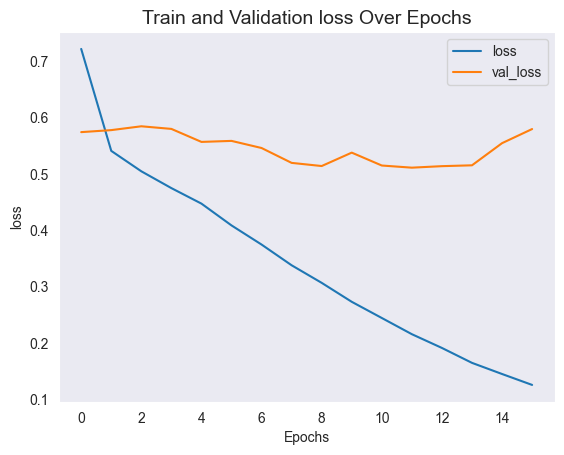

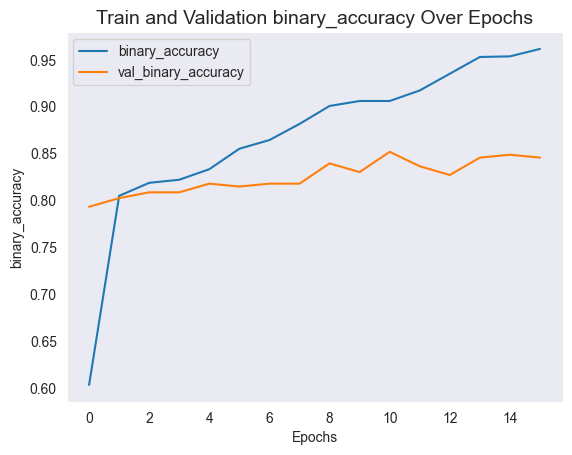

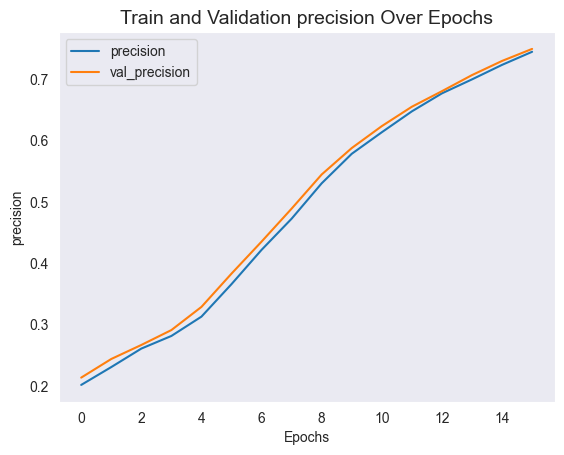

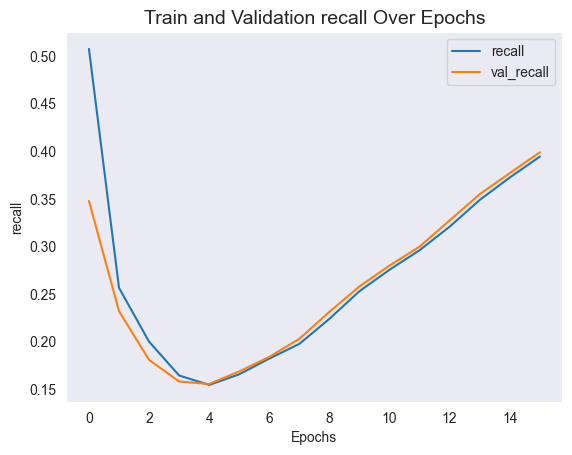

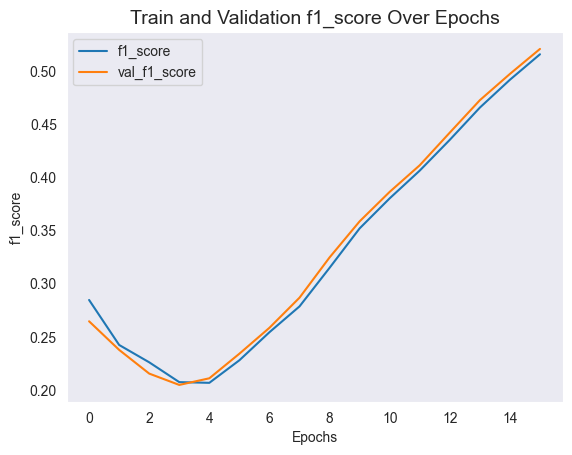

In [140]:
plot_result("loss")
plot_result("binary_accuracy")
plot_result("precision")
plot_result("recall")
plot_result("f1_score")


### Test part:
1. Predict labels for the test set using the model.
2. Convert these predicted probabilities to binary format (0 or 1) using a threshold of 5.
3. For each category:
* Extract the true and predicted labels for this category.
* Calculate and print the accuracy, precision, recall, and F1 score.
* Calculate and plot a confusion matrix for the category.


In [141]:
# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)

1/1 [==============================] - 0s 182ms/step


2023-05-25 10:24:31.652332: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [54,6]
	 [[{{node Placeholder/_1}}]]
2023-05-25 10:24:31.652887: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [996]
	 [[{{node Placeholder/_10}}]]


In [142]:
binary_predictions = np.round(y_pred)

In [143]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())

2023-05-25 10:24:32.698063: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_6' with dtype resource
	 [[{{node Placeholder/_6}}]]
2023-05-25 10:24:32.698559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_7' with dtype int64
	 [[{{node Placeholder/_7}}]]
/var/folders/jp/2wr1hx0s4zjdcnf63gtk75fw0000gq/T/ipykernel_94296/97231176.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vstack(test_dataset.map(lambda x, y: 

Category 1:

Accuracy: 0.8333333333333334
Precision: 0.9
Recall: 0.5294117647058824
F1 Score: 0.6666666666666667



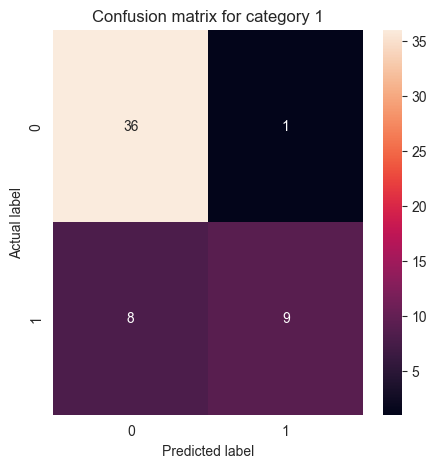

Category 2:

Accuracy: 0.8148148148148148
Precision: 0.8
Recall: 0.3076923076923077
F1 Score: 0.4444444444444444



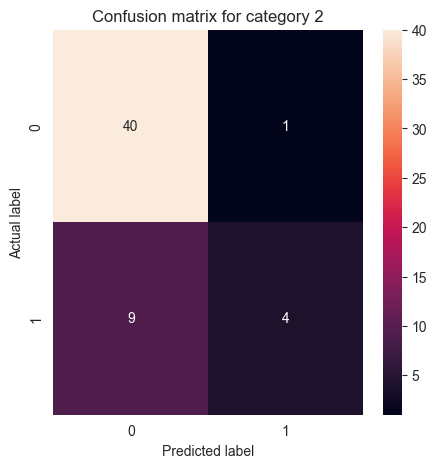

Category 3:

Accuracy: 0.7777777777777778
Precision: 1.0
Recall: 0.07692307692307693
F1 Score: 0.14285714285714288



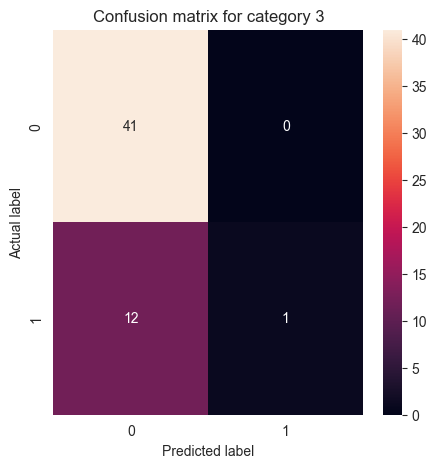

Category 4:

Accuracy: 0.8703703703703703
Precision: 0.25
Recall: 0.2
F1 Score: 0.22222222222222224



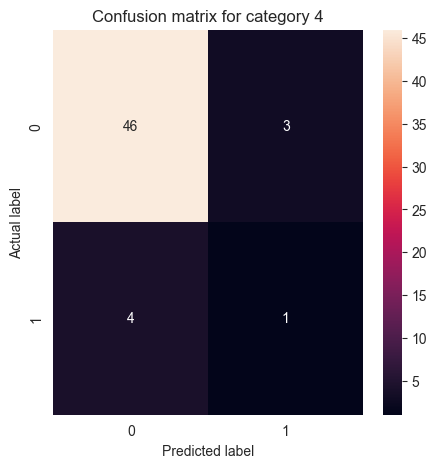

Category 5:

Accuracy: 0.7962962962962963
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



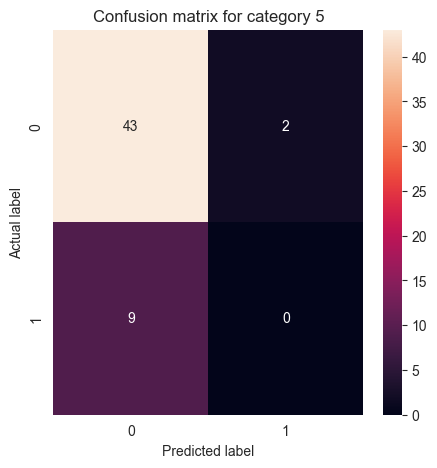

Category 6:

Accuracy: 0.9259259259259259
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



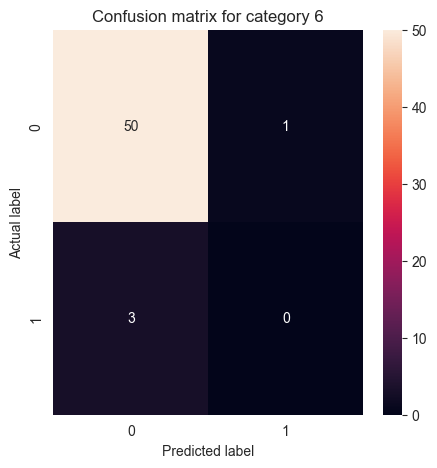

In [144]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

for i in range(binary_predictions.shape[1]):
    print(f"Category {i+1}:\n")
    true_labels = y_true[:, i]
    predicted_labels = binary_predictions[:, i]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix for category {i+1}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()

------------------------------------------------------------------------

### DISTRUBIOTION
 Lets check for the train and test data how many samples we have from each class:

In [145]:
from collections import Counter

# Flatten the list of categories
flat_categories = [category for sublist in train_df["category"] for category in sublist]

# Count the occurrences
counts = Counter(flat_categories)

# Print counts in a readable format
for category, count in counts.items():
    print(f" {category}: {count}")



 Future of work: 33
 Environment and climate resilience: 53
 Local identity: 52
 Land use: 75
 other: 62
 Mobility (transport): 8


In [146]:
# Flatten the list of categories
flat_categories = [category for sublist in test_df["category"] for category in sublist]

# Count the occurrences
counts = Counter(flat_categories)

# Print counts in a readable format
for category, count in counts.items():
    print(f" {category}: {count}")


 other: 13
 Environment and climate resilience: 13
 Future of work: 9
 Land use: 17
 Mobility (transport): 3
 Local identity: 5
